# Time Series Analysis using Unobserved Components Model

-By Varishu Pant  
    D19033  
    Praxis Business School  
    Bangalore  
Check it out- <a href="https://medium.com/@varishupant/tsa-ucm-python-5fde69d42e28">Blog on Medium</a>

### What is UCM?
Unobserved Components Model (UCM) (Harvey (1989)) performs a time series decomposition into components such as trend, seasonal, cycle, and the regression effects due to predictor series.

### Credits where they're due-
In an influential article, Harvey and Jaeger (1993) described the use of unobserved components models (also known as "structural time series models") to derive stylized facts of the business cycle. In particular, they make the argument that these goals are often better met using the unobserved components approach rather than the popular Hodrick-Prescott filter or Box-Jenkins ARIMA modeling techniques. Taking inspiration from Harvey and Jaeger I consider the following time series:
- US real GNP, "output", (GNPC96)
- US GNP implicit price deflator, "prices", (GNPDEF)

The time frame in the original paper varied across series but was broadly 1954–1989. Below I use data from the period 1970–2020 for all series. Although the unobserved components approach allows isolating a seasonal component within the model, the series considered in the paper, and here, are already seasonally adjusted. All data series considered here are taken from the Federal Reserve Economic Data (FRED). Conveniently, the Python library Pandas can download data from FRED directly.

You can expect a deep dive into the theory behind UCM as well as the hands-on implementation of UCM on real-world data.

## Importing Required Libraries

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from IPython.display import display, Latex

## Getting Data

In [108]:
from pandas_datareader.data import DataReader

# Get the raw data
start = '1970-01'      #From 1/1/1970
end = '2020-01'        #Till 1/7/2019
us_gnp = DataReader('GNPC96', 'fred', start=start, end=end)
us_gnp_deflator = DataReader('GNPDEF', 'fred', start=start, end=end)

# Construct the dataframe
dta = pd.concat(map(np.log, (us_gnp, us_gnp_deflator)), axis=1)
dta.columns = ['US GNP','US Prices']
dates = dta.index._mpl_repr()

In [109]:
dta.head()

,US GNP,US Prices
DATE,,
1970-01-01,8.51,3.06
1970-04-01,8.51,3.07
1970-07-01,8.52,3.08
1970-10-01,8.51,3.09
1971-01-01,8.54,3.11


In [118]:
dta.tail()

,US GNP,US Prices
DATE,,
2018-07-01,9.85,4.71
2018-10-01,9.85,4.71
2019-01-01,9.86,4.71
2019-04-01,9.87,4.72
2019-07-01,9.87,4.72


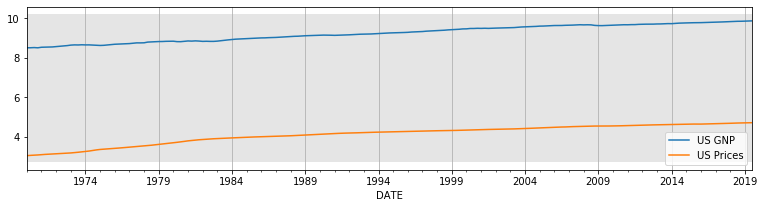

In [110]:
ax = dta.plot(figsize=(13,3))
ylim = ax.get_ylim()
ax.xaxis.grid()
ax.fill_between(dates, ylim[0]+1e-5, ylim[1]-1e-5,facecolor='k', alpha=0.1);

## About the Model-

## Unobserved Components
The unobserved components model available in statsmodels can be written as:

$y_t = \underbrace{\mu_{t}}_{\text{trend}} + \underbrace{\gamma_{t}}_{\text{seasonal}} + \underbrace{c_{t}}_{\text{cycle}} + \sum_{j=1}^k \underbrace{\beta_j x_{jt}}_{\text{explanatory}} + \underbrace{\varepsilon_t}_{\text{irregular}}$

Now we know: Response Time Series = Superposition of components such as Trend, Seasons, Cycles, and Regression effects…
Each component in the model captures some important features of the series dynamics. Components in the model have their probabilistic models. The probabilistic component models include meaningful deterministic patterns as special cases.

### Trend
The trend component is a dynamic extension of a regression model that includes an intercept and linear time-trend.

$\begin{split}\begin{align}
\underbrace{\mu_{t+1}}_{\text{level}} & = \mu_t + \nu_t + \eta_{t+1} \qquad & \eta_{t+1} \sim N(0, \sigma_\eta^2) \\\\
\underbrace{\nu_{t+1}}_{\text{trend}} & = \nu_t + \zeta_{t+1} & \zeta_{t+1} \sim N(0, \sigma_\zeta^2) \\
\end{align}\end{split}$

where the level is a generalization of the intercept term that can dynamically vary across time, and the trend is a generalization of the time-trend such that the slope can dynamically vary across time.
For both elements (level and trend), we can consider models in which:
The element is included vs excluded (if the trend is included, there must also be a level included).
The element is deterministic vs stochastic (i.e. whether or not the variance on the error term is confined to be zero or not)  
Trends are loosely defined as the natural tendency of the series to increase or decrease or remain constant over a period of time in absence of any other influencing variable.UCM can model trend in two ways; first being the random walk model implying that trend remains roughly constant over the time period of the series, and the second being locally linear trend having an upward or downward slope.


### Seasonal
The seasonal component is written as:

$\gamma_t = - \sum_{j=1}^{s-1} \gamma_{t+1-j} + \omega_t \qquad \omega_t \sim N(0, \sigma_\omega^2)$

The periodicity (number of seasons) is s, and the defining character is that (without the error term), the seasonal components sum to zero across one complete cycle. The inclusion of an error term allows the seasonal effects to vary over time.

The variants of this model are:

-The periodicity s

-Whether or not to make the seasonal effects stochastic.

If the seasonal effect is stochastic, then there is one additional parameter to estimate via MLE (the variance of the error term).

A seasonal pattern exists when there exists a consistent pattern of variation influenced by seasonal factors (e.g., the quarter of the year, or day of the week, etc.).
#### Representations of Seasonal Pattern(Period=s)-
As a list of s numbers that sum to zero
As a sum of [s/2] deterministic, undamped cycles, called harmonics, of periods s, s/2, s/3, …

Here [s/2] = s/2 if s is even and [s/2] = (s-1)/2 if s is odd.
Example: For s = 12, the seasonal pattern can always be written as a sum of six cycles with periods 12, 6, 4, 3, 2.4, and 2.


### Cycle
The cyclical component is intended to capture cyclical effects at time frames much longer than captured by the seasonal component. For example, in economics the cyclical term is often intended to capture the business cycle, and is then expected to have a period between “1.5 and 12 years” (see Durbin and Koopman).

The cycle is written as:

$\begin{split}\begin{align}
c_{t+1} & = c_t \cos \lambda_c + c_t^* \sin \lambda_c + \tilde \omega_t \qquad & \tilde \omega_t \sim N(0, \sigma_{\tilde \omega}^2) \\\\
c_{t+1}^* & = -c_t \sin \lambda_c + c_t^* \cos \lambda_c + \tilde \omega_t^* & \tilde \omega_t^* \sim N(0, \sigma_{\tilde \omega}^2)
\end{align}\end{split}$

The parameter λc (the frequency of the cycle) is an additional parameter to be estimated by MLE. If the seasonal effect is stochastic, then there is one another parameter to estimate (the variance of the error term - note that both of the error terms here share the same variance, but are assumed to have independent draws).



### Irregular
The irregular component is assumed to be a white noise error term. Its variance is a parameter to be estimated by MLE; i.e.

$\varepsilon_t \sim N(0, \sigma_\varepsilon^2)$

In some cases, we may want to generalize the irregular component to allow for autoregressive effects:

$\varepsilon_t = \rho(L) \varepsilon_{t-1} + \epsilon_t, \qquad \epsilon_t \sim N(0, \sigma_\epsilon^2)$

In this case, the autoregressive parameters would also be estimated via MLE.

### Regression effects

We may want to allow for explanatory variables by including additional terms

$\sum_{j=1}^k \beta_j x_{jt}$

or for intervention effects by including  

$\begin{split}\begin{align}
\delta w_t \qquad \text{where} \qquad w_t & = 0, \qquad t < \tau, \\\\
& = 1, \qquad t \ge \tau
\end{align}\end{split}$  

These additional parameters could be estimated via MLE or by including them as components of the state space formulation.

## Fitting UCM Models

Since the data is already seasonally adjusted and there are no obvious explanatory variables, the generic model considered is:  
$y_t = \underbrace{\mu_{t}}_{\text{trend}} + \underbrace{c_{t}}_{\text{cycle}} + \underbrace{\varepsilon_t}_{\text{irregular}}$  
The irregular will be assumed to be white noise, and the cycle will be stochastic and damped. The final modeling choice is the specification to use for the trend component. Harvey and Jaeger consider two models:

Local linear trend (the “unrestricted” model)

Smooth trend (the “restricted” model, since we are forcing ση=0)

Below, we construct kwargs dictionaries for each of these model types. Notice that rather that there are two ways to specify the models. One way is to specify components directly, as in the table above. The other way is to use string names which map to various specifications.

In [111]:
# Model specifications
# Unrestricted model, using string specification
unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}
# local linear trend model with a stochastic damped cycle:
# unrestricted_model = {
#     'irregular': True, 'level': True, 'stochastic_level': True, 'trend': True, 'stochastic_trend': True,
#     'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
# 
# The restricted model forces a smooth trend
restricted_model = {
    'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

# smooth trend model with a stochastic damped cycle. Notice
# that the difference from the local linear trend model is that
# `stochastic_level=False` here.

We now fit the following models:  

Output, unrestricted model  
Prices, unrestricted model  
Prices, restricted model

In [112]:
# Output
output_mod = sm.tsa.UnobservedComponents(dta['US GNP'], **unrestricted_model)
output_res = output_mod.fit(method='powell', disp=False)

# Prices
prices_mod = sm.tsa.UnobservedComponents(dta['US Prices'], **unrestricted_model)
prices_res = prices_mod.fit(method='powell', disp=False)

prices_restricted_mod = sm.tsa.UnobservedComponents(dta['US Prices'], **restricted_model)
prices_restricted_res = prices_restricted_mod.fit(method='powell', disp=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


For unobserved components models,it is often more instructive to plot the estimated unobserved components (e.g. the level, trend, and cycle) themselves to see if they provide a meaningful description of the data.

## Inference

Let's summarize restricted plot model-

In [117]:
print(prices_res.summary())

                            Unobserved Components Results                            
Dep. Variable:                     US Prices   No. Observations:                  199
Model:                    local linear trend   Log Likelihood                 887.254
                   + damped stochastic cycle   AIC                          -1762.508
Date:                       Tue, 14 Jan 2020   BIC                          -1742.870
Time:                               20:46:50   HQIC                         -1754.557
Sample:                           01-01-1970                                         
                                - 07-01-2019                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.411e-08   4.26e-07      0.033      0

**Observation-**
We observe from the estimated coefficient values that damping cycle and frequency cycle are important components of this model. Also coefficient for irregular components are almost zero indicating there isn't much error in the model.

Let's plot restricted price model-

The plot_components method of the fit object can be used to show plots and confidence intervals of each of the estimated states, as well as a plot of the observed data versus the one-step-ahead predictions of the model to assess fit.

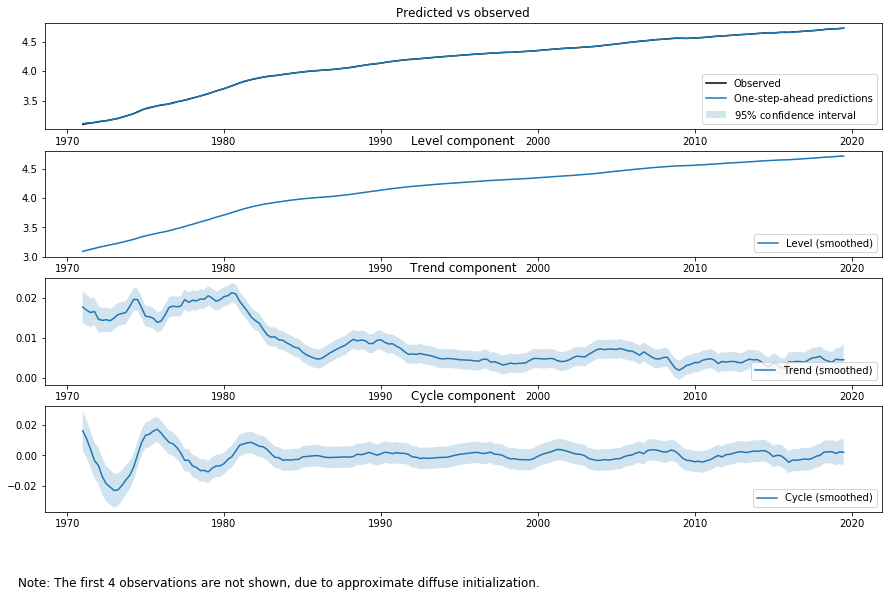

In [113]:
fig = prices_res.plot_components(legend_loc='lower right', figsize=(15, 9));

We see that the spread of the trend and cycle component is a lot lesser than the level component but on the other hand, there is way more noise in trend and cycle components compared to level.

Let's compare the 3 models using their parameters-

In [114]:
# Create Table I
table_i = np.zeros((3,6))

start = dta.index[0]
end = dta.index[-1]
time_range = '%d:%d-%d:%d' % (start.year, start.quarter, end.year, end.quarter)
models = [
    ('US GNP', time_range, 'None'),
    ('US Prices', time_range, 'None'),
    ('US Prices', time_range, r'$\sigma_\eta^2 = 0$'),
    ]
index = pd.MultiIndex.from_tuples(models, names=['Series', 'Time range', 'Restrictions'])
parameter_symbols = [
    r'$\sigma_\zeta^2$', r'$\sigma_\eta^2$', r'$\sigma_\kappa^2$', r'$\rho$',
    r'$2 \pi / \lambda_c$', r'$\sigma_\varepsilon^2$',
]

i = 0
for res in (output_res,prices_res, prices_restricted_res):
    if res.model.stochastic_level:
        (sigma_irregular, sigma_level, sigma_trend,
         sigma_cycle, frequency_cycle, damping_cycle) = res.params
    else:
        (sigma_irregular, sigma_level,
         sigma_cycle, frequency_cycle, damping_cycle) = res.params
        sigma_trend = np.nan
    period_cycle = 2 * np.pi / frequency_cycle

    table_i[i, :] = [
        sigma_level*1e7, sigma_trend*1e7,
        sigma_cycle*1e7, damping_cycle, period_cycle,
        sigma_irregular*1e7
    ]
    i += 1

pd.set_option('float_format', lambda x: '%.4g' % np.round(x, 2) if not np.isnan(x) else '-')
table_i = pd.DataFrame(table_i, index=index, columns=parameter_symbols)
table_i

$\sigma_\zeta^2$  \
Series    Time range    Restrictions                            
US GNP    1970:1-2019:3 None                            62.29   
US Prices 1970:1-2019:3 None                            10.78   
                        $\sigma_\eta^2 = 0$             13.45   

                                             $\sigma_\eta^2$  \
Series    Time range    Restrictions                           
US GNP    1970:1-2019:3 None                            3.86   
US Prices 1970:1-2019:3 None                            15.3   
                        $\sigma_\eta^2 = 0$                -   

                                             $\sigma_\kappa^2$  $\rho$  \
Series    Time range    Restrictions                                     
US GNP    1970:1-2019:3 None                             356.9    0.93   
US Prices 1970:1-2019:3 None                             16.91    0.96   
                        $\sigma_\eta^2 = 0$              26.99    0.96   

                                             $2 \pi / \lambda_c$  \
Series    Time range    Restrictions                               
US GNP    1970:1-2019:3 None                               24.68   
US Prices 1970:1-2019:3 None                               23.69   
                        $\sigma_\eta^2 = 0$                23.93   

                                             $\sigma_\varepsilon^2$  
Series    Time range    Restrictions                                 
US GNP    1970:1-2019:3 None                                      0  
US Prices 1970:1-2019:3 None                                   0.14  
                        $\sigma_\eta^2 = 0$                    0.03

**Observations-**
- Coefficients are in the order - - level, trend,cycle, damping_cycle, period_cycle(= $2 \pi /$frequency_cycle) and irregular.
- Also, all values except damping and period cycles are scaled up by multiplying 1e7.
- For the unrestricted model on GNP, the coefficient of the period cycle is 24.63, highest among others, signifying that it is the most important component for this model.
- In the restricted price model, there is no coefficient for trend as our restriction states that trend is not stochastic.
- Relatively, cycle component is stronger for GNP model than other models.

**NOTE FOR READERS-**  
Hi! Hope this was helpful! For more information on different variants of component models (example Seasonal models can be divided into 2 types namely,Stochastic Dummy Variable Seasonal Model and Deterministic Dummy Variable Seasonal Model) ,head over to my blog on medium. Here's the link-
<a href="https://medium.com/@varishupant/tsa-ucm-python-5fde69d42e28">Blog on Medium</a>